## Preparando os dos Dados para Previsão Futura

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Carregando os dados
df = pd.read_csv('dados/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#Aplicando a Limpeza e transformações básicas nos dados
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

cols_to_replace = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols_to_replace:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})

#Realiznado o One-Hot Encoding
df_encoded = pd.get_dummies(df.drop(['customerID', 'Churn'], axis=1), drop_first=True)
y = df['Churn'].map({'No': 0, 'Yes': 1})

#Dividindo em treino/teste
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.3, random_state=42, stratify=y)

#Treinando o modelo (Fase mais Legal, rsrs)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

#### Simulando a Probabilidade de Churn no Futuro

In [4]:
#Prevendo as probabilidades
probabilities = model.predict_proba(X_test)[:, 1]
df_pred = pd.DataFrame({
    'CustomerID': df.loc[X_test.index, 'customerID'],
    'Churn_Probability': probabilities,
    'Actual_Churn': y_test.map({0: 'No', 1: 'Yes'})
})

#Exibindo o top 10 clientes com maior risco
print("Top 10 Clientes em Risco:")
print(df_pred.sort_values(by='Churn_Probability', ascending=False).head(10))

Top 10 Clientes em Risco:
      CustomerID  Churn_Probability Actual_Churn
4585  1069-XAIEM           0.992019          Yes
4517  2012-NWRPA           0.990419          Yes
6623  9248-OJYKK           0.987010          Yes
2280  2754-SDJRD           0.983850           No
2464  2609-IAICY           0.982760          Yes
1401  5419-CONWX           0.981028          Yes
5826  9507-EXLTT           0.980663          Yes
3906  6372-RFVNS           0.979238          Yes
1731  8375-DKEBR           0.978843          Yes
6317  7493-TPUWZ           0.978333          Yes


## Visualizações com Interação (Utilizando o Plotly)

#### Distribuição da Probabilidade de Churn

In [5]:
fig = px.histogram(df_pred, x='Churn_Probability', nbins=50, title='Distribuição da Probabilidade de Churn')
fig.show()

#### Clientes por Faixa de Risco

In [ ]:
#Definindo as faixas de risco
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']
df_pred['Risk_Level'] = pd.cut(df_pred['Churn_Probability'], bins=bins, labels=labels)

risk_counts = df_pred['Risk_Level'].value_counts().reset_index()
risk_counts.columns = ['Risk_Level', 'Count']

fig = px.bar(risk_counts, x='Risk_Level', y='Count', title='Clientes por Nível de Risco')
fig.update_xaxes(categoryorder="array", categoryarray=labels)
fig.show()

#### Total de Churn Previsto nos Próximos Meses

In [8]:
#Tranformando 'Monthly_Churn_Rate' para tipo numérico
df_pred['Monthly_Churn_Rate'] = pd.to_numeric(df_pred['Monthly_Churn_Rate'], errors='coerce')

#Simulando o churn nos próximos meses
months = list(range(1, 7))
predicted_churns = []

for month in months:
    churned = (df_pred['Monthly_Churn_Rate'] * (1 - df_pred['Monthly_Churn_Rate'])**(month-1)).sum()
    predicted_churns.append(churned)

#DataFrame com a previsão
forecast_df = pd.DataFrame({
    'Month': months,
    'Predicted_Churns': predicted_churns
})

#Criando o Gráfico
import plotly.express as px
fig = px.line(forecast_df, x='Month', y='Predicted_Churns', markers=True, title='Previsão de Cancelamentos Futuros')
fig.show()

#### Importância das Features do Modelo

Top 10 Features Mais Importantes:
                           Feature  Importance
9      InternetService_Fiber optic    0.481770
18               Contract_Two year    0.157848
17               Contract_One year    0.086992
10              InternetService_No    0.054861
0                           tenure    0.021353
16             StreamingMovies_Yes    0.020876
21  PaymentMethod_Electronic check    0.014568
19            PaperlessBilling_Yes    0.014124
8                MultipleLines_Yes    0.013850
14                 TechSupport_Yes    0.011479


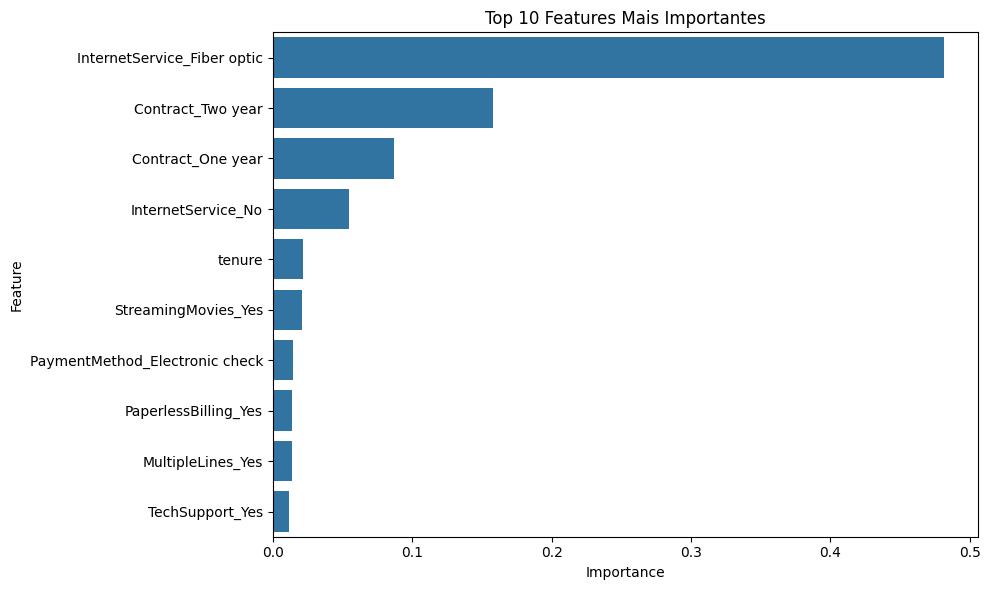

In [9]:
#Importância das features do modelo XGBoost
importances = model.feature_importances_
feature_names = X_train.columns

#Criando o DataFrame
features_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

#Mostrando top 10 features no gráfico
print("Top 10 Features Mais Importantes:")
print(features_df.head(10))

#Criando o gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=features_df.head(10))
plt.title('Top 10 Features Mais Importantes')
plt.tight_layout()
plt.show()